In [ ]:
# default_exp models.nbeats

In [ ]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# N-Beats model

> A basic architecture for time series forecasting.


In [ ]:
# hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#export
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.callback.hook import num_features_model
from fastai2.callback.all import *
from fastai2.torch_core import *
from torch.autograd import Variable
from fastseq.all import *

## Blocks

In [ ]:
# export

def linspace(lookback, horizon):
    lin_space = torch.linspace(
        -lookback, horizon, lookback + horizon
    )
    b_ls = lin_space[:lookback]
    f_ls = lin_space[lookback:]
    return b_ls, f_ls


In [ ]:
# export
class Block(Module):
    def __init__(self, fnc_f, fnc_b=None):
        sizes = [self.lookback] + self.layers
        ps = ifnone(self.ps, L([0])*len(self.layers))
        actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None]
        _layers = [LinBnDrop(sizes[i], sizes[i+1], bn=self.use_bn, p=p, act=a)
                       for i,(p,a) in enumerate(zip(ps, actns))]
        self.layers = nn.Sequential(*_layers)
        self.att = LinBnDrop(sizes[-1], 1)
        if self.share_thetas:
            self.theta_f_fc = self.theta_b_fc = LinBnDrop(sizes[-1], self.thetas_dim)
        else:
            self.theta_b_fc = LinBnDrop(sizes[-1], self.thetas_dim)
            self.theta_f_fc = LinBnDrop(sizes[-1], self.thetas_dim)
            
        b, f = linspace(self.lookback, self.horizon)
        self.backcast_linspace = Variable(b, requires_grad=False).to(self.device)
        self.forecast_linspace = Variable(f, requires_grad=False).to(self.device)
        self.fnc_f = fnc_f
        self.fnc_b = ifnone(fnc_b, fnc_f)
        self.to(self.device)
        self.y_range = getattr(self,'y_range', None)
        
    def forward(self, x):
        # trend
        x = self.layers(x)
        att = torch.sigmoid(self.att(x))
        theta_b = self.apply_range(self.theta_b_fc(x)) * att
        theta_f = self.apply_range(self.theta_f_fc(x)) * att
        backcast = self.fnc_b(theta_b, self.backcast_linspace)
        forecast = self.fnc_f(theta_f, self.forecast_linspace)
        return {'b':backcast,'f': forecast, 'theta': theta_b + theta_f}
    
    def apply_range(self, x): 
        if self.y_range is None:
            return x
        return (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0]

In [ ]:
# export
def bias_model(thetas, t):
    r= torch.mm(t[None,:].float().T,thetas[:,0][None,:]).T 
    if thetas.shape[-1]==2:
        return r+thetas[:,1][:,None]
    return r

class BiasBlock(Block):
    def __init__(
        self, layers:L, device, thetas_dim=2, lookback=10, horizon=5, use_bn=True, bn_final=False, ps:L=None
    ):
        share_thetas=True
        assert thetas_dim <= 2, f"thetas_dim for BaisBlock must be < than 2, is now {thetas_dim}"
        store_attr(self,"device,layers,thetas_dim,use_bn,ps,lookback,horizon,bn_final,share_thetas" ) 
        self.layers=L(self.layers[-1])
        super().__init__(bias_model)        
        self.to(device)

In [ ]:
mdl = BiasBlock([256], device=torch.device('cuda'), lookback=100, horizon=10)
dct = mdl(torch.randn(64,100).to(torch.device('cuda')))
test_eq(dct['b'].shape, (64,100))
test_eq(dct['f'].shape, (64,10))
test_eq(dct['theta'].shape,(64,2))

In [ ]:
# export
class LinearD(nn.Linear):        
    def forward(self, x, *args, **kwargs):
        return super().forward(x)
        
class GenericBlock(Block):
    def __init__(
        self, layers:L, thetas_dim:int, device, lookback=10, horizon=5, use_bn=True, bn_final=False, ps:L=None, share_thetas=True, y_range=[-.5,.5]
    ):
        store_attr(self,"y_range,device,layers,thetas_dim,use_bn,ps,lookback,horizon,bn_final,share_thetas" ) 
        super().__init__(LinearD(self.thetas_dim, self.horizon),LinearD(self.thetas_dim, self.lookback))        
        self.to(device)
        

In [ ]:
mdl = GenericBlock([256], thetas_dim=4, device=torch.device('cuda'), lookback=100, horizon=10)
dct = mdl(torch.randn(64,100).to(torch.device('cuda')))
test_eq(dct['b'].shape, (64,100))
test_eq(dct['f'].shape, (64,10))

In [ ]:
# export

def seasonality_model(thetas, t):
    p = thetas.size()[-1]
    assert p < 10, "thetas_dim is too big."
    p1, p2 = (p // 2, p // 2) if p % 2 == 0 else (p // 2, p // 2 + 1)
    s1 = [torch.cos(2 * np.pi * i * t)[None,:] for i in range(p1)] # H/2-1
    s2 = [torch.sin(2 * np.pi * i * t)[None,:] for i in range(p2)]
    S = torch.cat([*s1, *s2])
    return thetas.mm(S)

class SeasonalityBlock(Block):
    def __init__(
        self, layers:L, thetas_dim:int, device, lookback=10, horizon=5, use_bn=True, bn_final=False, ps:L=None, share_thetas=False,y_range=[-.5,.5]
    ):       
        store_attr(self,"y_range,device,layers,thetas_dim,use_bn,ps,lookback,horizon,bn_final,share_thetas" ) 
        super().__init__(seasonality_model )        
        self.to(device)

In [ ]:
mdl = SeasonalityBlock([256], thetas_dim=4, device=torch.device('cuda'), lookback=100, horizon=10)
dct = mdl(torch.randn(64,100).to(torch.device('cuda')))
test_eq(dct['b'].shape, (64,100))
test_eq(dct['f'].shape, (64,10))

In [ ]:
# export
def trend_model(thetas, t):
    p = thetas.size()[-1]
    assert p <= 4, "thetas_dim is too big."
    a = [torch.pow(t, i)[None,:] for i in range(p)]
    T = torch.cat(a).float()
    return thetas.mm(T)

class TrendBlock(Block):
    def __init__(
        self, layers:L, device, thetas_dim, lookback=10, horizon=5, use_bn=True, bn_final=False, ps:L=None, share_thetas=False, y_range=[-.05,.05]
    ):
        store_attr(self,"y_range,device,layers,thetas_dim,use_bn,ps,lookback,horizon,bn_final,share_thetas" ) 
        super().__init__(trend_model)        
        self.to(device)

In [ ]:
mdl = TrendBlock([256], thetas_dim=4, device=torch.device('cuda'), lookback=100, horizon=10)
dct = mdl(torch.randn(64,100).to(torch.device('cuda')))
test_eq(dct['b'].shape, (64,100))
test_eq(dct['f'].shape, (64,10))
test_eq(dct['theta'].shape,(64,4))

In [ ]:
# export

# blocks= defaultdict(GenericBlock)
# blocks.update({"seasonality": SeasonalityBlock,
#          "trend": TrendBlock,
#          "generic": GenericBlock})
# blocks_int= {i:v for i,v in enumerate(blocks.items())}
# not pritty but still works better
def select_block(o):
    if isinstance(o,int):
        if o == 0:
            return SeasonalityBlock
        elif o == 1:
            return TrendBlock
        elif o == 2:
            return BaisBlock
        else:
            return GenericBlock
    else:
        if o == 'seasonality':
            return SeasonalityBlock
        elif o == 'trend':
            return TrendBlock
        elif o =='bias':
            return BiasBlock
        else:
            return GenericBlock

In [ ]:
# export
class NBeatsNet(Module):
    def __init__(
        self,
        device,
        stack_types=('bias', 'trend', 'seaonality'),
        nb_blocks_per_stack=3,
        horizon=5,
        lookback=10,
        thetas_dim=None,
        share_weights_in_stack=False,
        layers= [200,100],
    ):
        super(NBeatsNet, self).__init__()
        thetas_dim = ifnone(thetas_dim,[3 if 'bias' not in o else 2 for o in stack_types  ])
        stack_types= L(stack_types)
        store_attr(self,'device,horizon,lookback,layers,nb_blocks_per_stack,share_weights_in_stack,stack_types,thetas_dim,device')
        self.stacks = []
        self._str = "| N-Beats\n"
        
        self.bn = BatchNorm(lookback, ndim=2)        
        stacks = OrderedDict()        
        for stack_id in range(len(self.stack_types)):
            
            stacks[str(self.stack_types[stack_id]) + str(stack_id)] = self.create_stack(stack_id)
        self.stacks = nn.Sequential(stacks)
        
    def create_stack(self, stack_id):
        stack_type = self.stack_types[stack_id]
        self._str += f"| --  Stack {stack_type.title()} (#{stack_id}) (share_weights_in_stack={self.share_weights_in_stack})\n"
        
        blocks = []
        for block_id in range(self.nb_blocks_per_stack):
            block_init = select_block(stack_type)
            if self.share_weights_in_stack and block_id != 0:
                block = blocks[-1]  # pick up the last one when we share weights.
            else:
                block = block_init(
                    layers = self.layers,
                    thetas_dim = self.thetas_dim[stack_id],
                    device = self.device,
                    lookback = self.lookback,
                    horizon = self.horizon,
                )
            self._str += f"     | -- {block}\n"
            blocks.append(block)
            
        return nn.Sequential(*blocks)

    def forward(self, backcast):
        backcast = backcast.view([-1,backcast.shape[-1]])
        forecast = torch.zeros(
            size=(backcast.size()[0], self.horizon,)
        )  # maybe batch size here.
        
        dct = defaultdict(dict)
        for stack_id, names in enumerate(self.stacks.named_children()):
            name = names[0]
            for block_id in range(len(self.stacks[stack_id])):
                dct[name+'_'+str(block_id)] = self.stacks[stack_id][block_id](backcast)
                backcast = backcast.to(self.device) - dct[name+'_'+str(block_id)]['b']
                forecast = forecast.to(self.device) + dct[name+'_'+str(block_id)]['f']
        return forecast[:,None,:], backcast[:,None,:], dct



In [ ]:
mdl = NBeatsNet(torch.device('cpu'), stack_types=('seaonality'), )
f, b, dct = mdl(torch.randn(64,1,10))
print(f.shape,b.shape)
print([(stack, o['theta'].mean(0)) for stack,o in dct.items()])

torch.Size([64, 1, 5]) torch.Size([64, 1, 10])
[('seaonality0_0', tensor([ 0.0036, -0.0095, -0.0154], grad_fn=<MeanBackward1>)), ('seaonality0_1', tensor([0.0207, 0.0120, 0.0043], grad_fn=<MeanBackward1>)), ('seaonality0_2', tensor([ 0.0072, -0.0119, -0.0020], grad_fn=<MeanBackward1>))]


## Metrics 

In [ ]:
# export
from fastai2.data.all import *
from fastai2.optimizer import *
from fastai2.learner import *

In [ ]:
#export
class NBeatsTheta(Metric):
    "The sqaure of the `theta` for every block. "
    def reset(self):           self.total,self.count = 0.,0
    def accumulate(self, learn):
        bs = find_bs(learn.yb)        
        self.total += to_detach(learn.n_beats_trainer.metrics['theta'].mean())*bs
        self.count += bs
    @property
    def value(self): return self.total/self.count if self.count != 0 else None
    @property
    def name(self):  return "theta"

In [ ]:
#export
class NBeatsBackwards(Metric):
    "The loss according to the `loss_func` on the backwards part of the time-serie."
    def reset(self):           self.total,self.count = 0.,0
    def accumulate(self, learn):
        bs = find_bs(learn.yb)        
        self.total += to_detach(learn.n_beats_trainer.metrics['b_loss'].mean())*bs
        self.count += bs
    @property
    def value(self): return self.total/self.count if self.count != 0 else None
    @property
    def name(self):  return "b_loss"

## Callback 

In [ ]:
# export
class NBeatsTrainer(Callback):
    "`Callback` that adds weights regularization the thetas in N-Beats training."
    def __init__(self, theta=0., b_loss=0.): 
        self.theta, self.b_loss = theta, b_loss
        self.metrics = {'theta':tensor([0.]), 'b_loss':tensor([0.])}
        self.b = None

    def begin_train(self): 
        self.out = defaultdict(dict)
        self.metrics = {'theta':tensor([0.]), 'b_loss':tensor([0.])}
        
    def begin_validate(self): 
        self.out = defaultdict(dict)
        self.metrics = {'theta':tensor([0.]), 'b_loss':tensor([0.])}
        
    def after_pred(self):
        self.b = self.pred[1] 
        self.pred[2]['total_b'] = self.pred[1] 
        self.out = concat_dct(self.pred[2], self.out)   
        self.learn.pred = self.pred[0]

    def after_loss(self):        
        # theta
        value=tensor([0.])
        for key in self.out.keys():
            if 'bias' not in key and 'total' not in key:
                v = self.out[key]['theta'].float().pow(2).mean()
                if self.theta != 0.:     
                    self.learn.loss += self.theta * v.item()
                value = value + v
        self.metrics['theta'] += value.clone().cpu().detach()
        
        # backwards 
        value = self.learn.loss_func(self.b.float(), *self.xb, reduction='mean') #* (1/self.learn.lh)
        if self.b_loss != 0.:
            self.learn.loss += self.b_loss * value.mean() 
        self.metrics['b_loss'] += value.sum().clone().detach()
            
    def theta_means(self):
        print({key:self.out[key]['theta'].float().mean(0) for key in self.out.keys() if 'total' not in key})

In [ ]:
# export
def CombinedLoss(*losses, ratio:dict=None):
    _ratio = defaultdict(lambda:1.)
    if ratio is not None:
        _ratio.update(ratio)    
    ratio = _ratio
    
    def _inner(pred, truth, *args,**kwargs):
        loss = None
        for _loss in losses:
            if loss is None:
                loss = ratio[_loss.__name__] * _loss(pred, truth, *args,**kwargs)
            else:
                loss += ratio[_loss.__name__] * _loss(pred, truth, *args,**kwargs)
        return loss
    
    return _inner
#     metrics = L()
#     for _loss in losses:
#         metrics.append(lambda pred, truth, *args,**kwargs: ratio[_loss.__name__] * _loss(pred, truth, *args,**kwargs))
#     print(metrics)
  

In [ ]:
y, y_hat = torch.arange(10).float(), torch.arange(10).float()+torch.randn(10)
loss_fnc = CombinedLoss(F.mse_loss,smape)
test_eq(F.mse_loss(y,y_hat)+smape(y,y_hat),loss_fnc(y, y_hat))

r = 10
loss_fnc = CombinedLoss(F.mse_loss, smape, ratio = {'mse_loss':r})
test_eq(r*F.mse_loss(y,y_hat)+smape(y,y_hat),loss_fnc(y, y_hat))


## Learner

In [ ]:
# export
from fastai2.basics import *
from fastseq.all import *

@delegates(NBeatsNet.__init__)
def nbeats_learner(dbunch:TSDataBunch, output_channels=None, metrics=None,cbs=None, theta=0., b_loss=0., loss_func=None, **kwargs):
    "Build a N-Beats style learner"    
    model = NBeatsNet(
        device = dbunch.train_dl.device,
        horizon = dbunch.train_dl.horizon,
        lookback = dbunch.train_dl.lookback, 
        **kwargs
       )
    
    loss_func = ifnone(loss_func, CombinedLoss(F.mse_loss, smape, ratio = {'smape':.0005}))
    learn = Learner(dbunch, model, loss_func=loss_func, opt_func= Adam, 
                    metrics=L(metrics)+L(mae, smape, F.mse_loss, NBeatsTheta(), NBeatsBackwards()),
                    cbs=L(NBeatsTrainer(theta, b_loss))+L(cbs)
                   )
    learn.lh = (learn.dbunch.train_dl.lookback/learn.dbunch.train_dl.horizon)
    return learn

In [ ]:
# hide
from fastseq.data.external import *
items = dummy_data_generator(50, 10, nrows=100)
data = TSDataBunch.from_items(items, horizon = 7)
learn = nbeats_learner(data,layers=[200,200,100], theta = .1, b_loss=.3, stack_types=('bias',"seasonality","trend"),
                       loss_func= CombinedLoss(F.mse_loss, smape, ratio = {'smape':.1}),)

learn.fit(1,.001)

Train:500; Valid: 800; Test 100


epoch,train_loss,valid_loss,mae,smape,mse_loss,theta,b_loss,time
0,54.444168,22.568893,1.468715,162.927887,2.911189,0.012795,52.712555,00:00


In [ ]:
learn.n_beats_trainer.theta_means()

{'bias0_0': tensor([0.0749, 0.4230], device='cuda:0'), 'bias0_1': tensor([-0.0916, -0.1928], device='cuda:0'), 'bias0_2': tensor([-0.0027,  0.0204], device='cuda:0'), 'seasonality1_0': tensor([ 0.0186, -0.0122,  0.0011], device='cuda:0'), 'seasonality1_1': tensor([-0.0014, -0.0018, -0.0076], device='cuda:0'), 'seasonality1_2': tensor([-0.0050,  0.0016, -0.0121], device='cuda:0'), 'trend2_0': tensor([-0.0001,  0.0004,  0.0009], device='cuda:0'), 'trend2_1': tensor([ 0.0004, -0.0003,  0.0009], device='cuda:0'), 'trend2_2': tensor([-0.0006,  0.0004, -0.0003], device='cuda:0')}


# Example

Train:10000; Valid: 2000; Test 1000


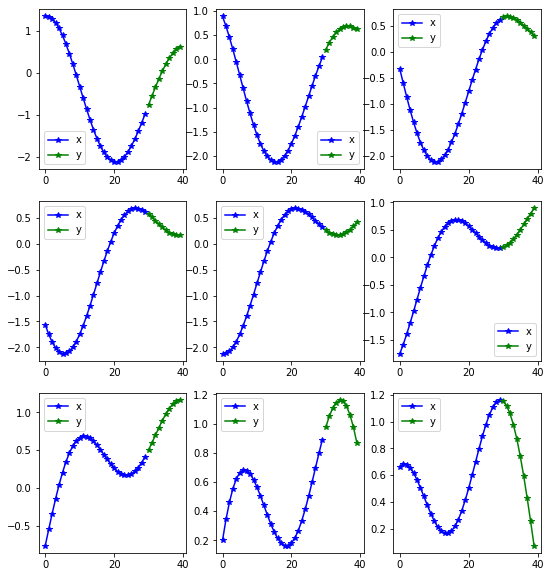

In [ ]:
from fastseq.data.external import *
items = dummy_data_generator(100, 10, nrows=1000)
data = TSDataBunch.from_items(items, horizon = 10,lookback = 30, step=5,bs=256)
data.show_batch()

In [ ]:
learn = nbeats_learner(data,layers=[200,200,100], stack_types=('bias',"seasonality","trend"), b_loss=.3,
                       loss_func= CombinedLoss(F.mse_loss, smape, ratio = {'smape':.001}),)

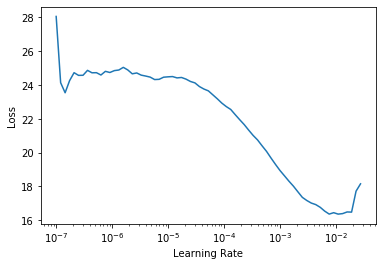

In [ ]:
from fastai2.callback.all import *
learn.lr_find()

epoch,train_loss,valid_loss,mae,smape,mse_loss,theta,b_loss,time
0,18.178520,14.297212,0.181533,31.933903,0.079921,0.124871,144.975555,00:05
1,17.270075,19.214819,0.244424,40.403549,0.135917,0.172058,195.148575,00:05
2,16.290117,27.952614,0.372702,58.358669,0.255693,0.279328,285.163605,00:05
3,10.994226,1.778254,0.381981,56.792931,0.262065,0.195712,14.856309,00:05
4,7.188978,12.829584,0.218430,38.567760,0.103934,0.197339,129.345917,00:05
5,5.551419,14.916412,0.235817,40.210484,0.115455,0.213161,150.825592,00:05
6,5.019040,19.268148,0.135851,27.081976,0.045280,0.221040,196.567657,00:05
7,5.032943,18.162281,0.184089,34.585873,0.067247,0.197586,185.102982,00:05
8,5.066977,16.587372,0.164897,29.853453,0.063923,0.216602,169.141327,00:05
9,5.066226,16.223530,0.163460,31.146919,0.062884,0.216778,165.352707,00:05


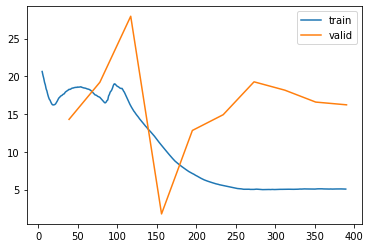

In [ ]:
learn.fit_one_cycle(10, 2e-3)
learn.recorder.plot_loss()

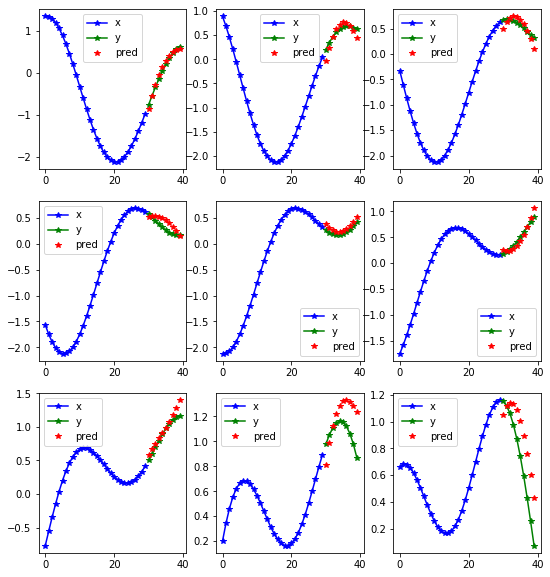

In [ ]:
learn.show_results(max_n=9)

In [ ]:
learn.loss_func = CombinedLoss(F.mse_loss, smape, ratio = {'smape':.1})

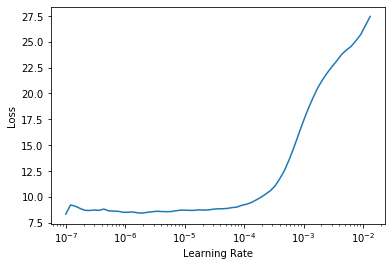

In [ ]:
from fastai2.callback.all import *
learn.lr_find()

epoch,train_loss,valid_loss,mae,smape,mse_loss,theta,b_loss,time
0,8.532592,19.352222,0.162675,31.057581,0.061726,0.215855,165.908295,00:05
1,8.620281,19.518784,0.160310,30.658815,0.055843,0.211288,168.037109,00:05
2,8.857574,19.607361,0.155785,29.138786,0.049432,0.203689,170.505646,00:05
3,9.237751,19.583757,0.155088,26.742493,0.049256,0.196080,172.669052,00:05
4,9.714969,19.901567,0.167914,27.211504,0.056266,0.189129,175.329559,00:05
5,10.238434,20.314842,0.188955,29.707283,0.067983,0.184168,176.848999,00:05
6,10.728833,20.642561,0.209086,31.931145,0.080079,0.180589,177.783707,00:05
7,11.121070,20.855978,0.221966,33.520287,0.088529,0.178658,178.243759,00:05
8,11.386755,20.943432,0.227712,34.238503,0.092557,0.177747,178.357269,00:05
9,11.531576,20.955973,0.228805,34.370968,0.093352,0.177516,178.340622,00:05


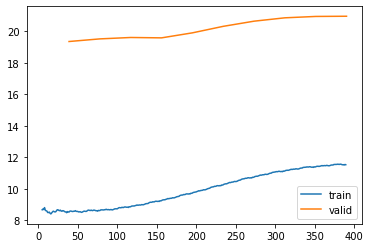

In [ ]:
learn.fit_one_cycle(10, 2e-6)
learn.recorder.plot_loss()

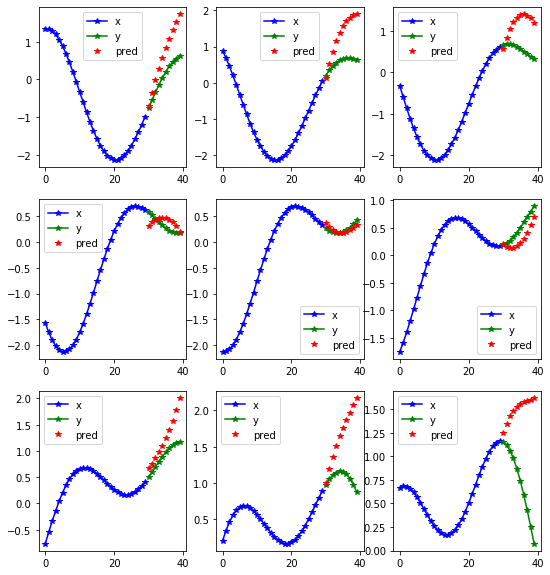

In [ ]:
learn.show_results(max_n=9)

In [ ]:
learn.n_beats_trainer.theta_means()

{'bias0_0': tensor([ 0.2099, -0.2519], device='cuda:0'), 'bias0_1': tensor([-0.0051, -0.2019], device='cuda:0'), 'bias0_2': tensor([-0.0581,  0.0877], device='cuda:0'), 'seasonality1_0': tensor([-0.2445, -0.0013,  0.1669], device='cuda:0'), 'seasonality1_1': tensor([ 0.0227, -0.0074, -0.0104], device='cuda:0'), 'seasonality1_2': tensor([-0.0095,  0.0216, -0.0125], device='cuda:0'), 'trend2_0': tensor([-0.0047,  0.0081, -0.0029], device='cuda:0'), 'trend2_1': tensor([-0.0005, -0.0018,  0.0011], device='cuda:0'), 'trend2_2': tensor([ 0.0005, -0.0019,  0.0007], device='cuda:0')}


## Second Example 

In [ ]:
learn = nbeats_learner(data,layers=[200,200,100], theta = .001, b_loss= .1, stack_types=('bias',"trend","seasonality"),
                       loss_func= CombinedLoss(F.mse_loss, smape, ratio = {'smape':.0005}))

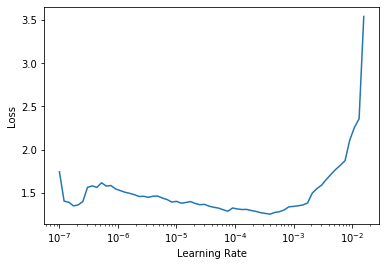

In [ ]:
from fastai2.callback.all import *
learn.lr_find()

epoch,train_loss,valid_loss,mae,smape,mse_loss,theta,b_loss,time
0,2.798711,3.908922,0.612834,544.621033,0.706019,4.119741,1243.326904,00:10
1,2.369781,1.799458,0.412477,441.479065,0.317924,4.805168,534.905640,00:10
2,2.178643,2.290974,0.507621,471.197845,0.527830,6.143695,643.786621,00:10
3,2.252007,3.111026,0.573795,523.396423,0.621248,6.860892,947.526184,00:09
4,2.136893,4.472634,0.717254,592.371887,0.980422,7.941977,1360.326782,00:10
5,2.011050,2.968499,0.535622,498.893402,0.596224,8.510410,906.720520,00:10
6,1.744837,2.953166,0.575680,527.660706,0.658864,8.509661,867.687561,00:10
7,1.550745,2.347571,0.475694,467.353485,0.471037,7.950303,703.435608,00:10
8,1.397406,2.306121,0.507522,491.555237,0.502975,8.057914,667.173523,00:10
9,1.325952,2.257413,0.501219,487.801880,0.495678,8.043340,650.794434,00:10


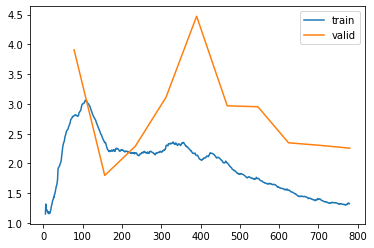

In [ ]:
learn.fit_one_cycle(10, 2e-3)
learn.recorder.plot_loss()

(#9) [(tensor([[-1.9608, -1.8617, -1.7167, -1.5245, -1.2838, -0.9929, -0.6501]]),),(tensor([[-1.9487, -1.7763, -1.5586, -1.2945, -0.9825, -0.6209, -0.2079]]),),(tensor([[-1.7924, -1.5465, -1.2651, -0.9473, -0.5921, -0.1986,  0.2346]]),),(tensor([[-1.5898, -1.2771, -0.9487, -0.6040, -0.2424,  0.1368,  0.5344]]),),(tensor([[-1.2847, -0.8893, -0.4901, -0.0865,  0.3222,  0.7364,  1.1569]]),),(tensor([[-1.4170, -1.4434, -1.4399, -1.4056, -1.3392, -1.2394, -1.1045]]),),(tensor([[-1.5683, -1.5341, -1.4702, -1.3753, -1.2477, -1.0859, -0.8878]]),),(tensor([[-1.6576, -1.5502, -1.4132, -1.2456, -1.0463, -0.8139, -0.5470]]),),(tensor([[-1.5777, -1.4098, -1.2238, -1.0192, -0.7951, -0.5506, -0.2847]]),)]


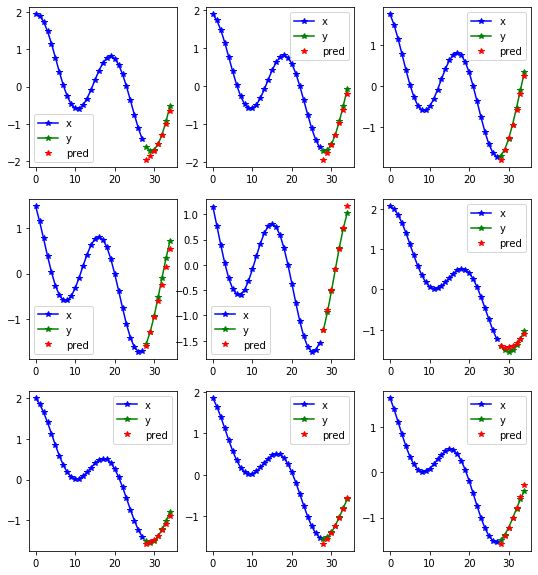

In [ ]:
learn.show_results(max_n=9)

In [ ]:
# hide
print(learn.summary())

NBeatsNet (Input shape: ['64 x 1 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          64 x 28              56         True      
________________________________________________________________
Linear               64 x 100             2,800      True      
________________________________________________________________
BatchNorm1d          64 x 100             200        True      
________________________________________________________________
Linear               64 x 1               100        True      
________________________________________________________________
BatchNorm1d          64 x 100             200        True      
________________________________________________________________
Linear               64 x 1               100        True      
________________________________________________________________
BatchNorm1d          64 x 28              56         True      
_________________________________________________________

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 03_data.load.ipynb.
Converted 04_data.transforms.ipynb.
Converted 05_models.wavenet.ipynb.
Converted 06_models.dnn.ipynb.
Converted 07_interpret.ipynb.
Converted 08_metrics.ipynb.
Converted 09_learner.ipynb.
Converted 10_models.nbeats-Copy1.ipynb.
Converted 10_models.nbeats.ipynb.
Converted 20_models.cnn.learner.ipynb.
Converted 21_models.cnn.transforms.ipynb.
Converted index.ipynb.
